In [1]:
# Enable code formatting using external plugin: nb_black.
%reload_ext nb_black

<IPython.core.display.Javascript object>

# K-Nearest Neighbor (KNN)

Implement KNN algorithm.

### Objective

1. Understanding KNN algorithm.
2. Given a query point <code>x<sub>q</sub></code>, predict its class using KNN.
3. Implement KNN algorithm.
4. Overfitting and Underfitting.
5. K-fold Cross validation.

# [1] Setup

### Import and configure required libraries

In [2]:
# Data manipulation libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# General imports
import math

# Library versions used in below EDA.
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

# Configure NumPy.
# Set `Line width` to Maximum 130 characters in the output, post which it will continue in next line.
np.set_printoptions(linewidth=130)

# Configure Pandas.
# Set display width to maximum 130 characters in the output, post which it will continue in next line.
pd.options.display.width = 130

# Configure Seaborn.
sns.set_style("whitegrid")  # Set white background with grid.
sns.set_palette("deep")  # Set color palette.
sns.set_context("paper", font_scale=1.5)  # Set font to scale 1.5 more than normal.

NumPy version: 1.21.5
Pandas version: 1.4.2
Matplotlib version: 3.5.1
Seaborn version: 0.11.2


<IPython.core.display.Javascript object>

#### Common functions

In [3]:
def is_empty(element) -> bool:
    """
    Function to check if input `element` is empty.

    Other than some special exclusions and inclusions,
    this function returns boolean result of Falsy check.
    """
    if (isinstance(element, int) or isinstance(element, float)) and element == 0:
        # Exclude 0 and 0.0 from the Falsy set.
        return False
    elif isinstance(element, str) and len(element.strip()) == 0:
        # Include string with only one or more empty space(s) into Falsy set.
        return True
    elif isinstance(element, bool):
        # Exclude False from the Falsy set.
        return False
    else:
        # Falsy check.
        return False if element else True


def all_zeros(numbers):
    """
    Function to check if all elements in the list are zero.
    """
    return all(n == 0 for n in numbers)


def groupby_count(items, key):
    """
    Function to count `key` in a list of items.
    """
    count = {}
    for index, item in enumerate(items):
        if is_empty(key(item)):
            raise ValueError(f"Specified key not found in the item at index: {index} in the list.")

        count[key(item)] = count.get(key(item), 0) + 1

    return count


ENABLE_LOG = False


def log(*args):
    """
    Function print when logging is enabled.
    """
    if ENABLE_LOG is True:
        print(*args)

<IPython.core.display.Javascript object>

### Load data-points from a `.csv` file

In [4]:
train_df = pd.read_csv("./Input/train.csv")
train_df.head()

,f1,f2,cl
0,5.0,11,1
1,10.0,10,2
2,1.0,8,1
3,2.0,10,2
4,6.0,10,1


<IPython.core.display.Javascript object>

In [5]:
train_df.shape

(82, 3)

<IPython.core.display.Javascript object>

Convert class-label column `cl` into `category` data type.

In [6]:
train_df["cl"] = train_df["cl"].astype("category")
train_df["cl"].dtype

CategoricalDtype(categories=[1, 2], ordered=False)

<IPython.core.display.Javascript object>

### Plot data-points

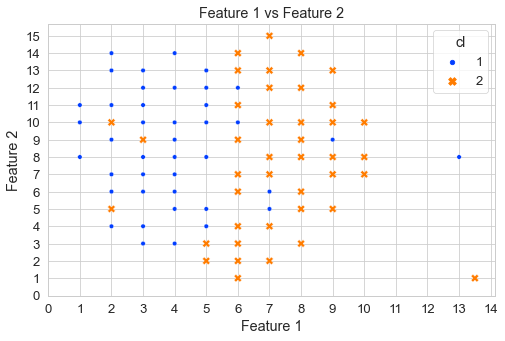

<IPython.core.display.Javascript object>

In [7]:
plt.figure(figsize=(8, 5))

sns.scatterplot(
    x="f1",
    y="f2",
    hue="cl",
    data=train_df,
    palette="bright",
    style="cl",
    markers=["o", "X"],
    size="cl",
    sizes=(60, 20),
)
plt.title("Feature 1 vs Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xticks(ticks=range(0, 15, 1))
plt.yticks(ticks=range(0, 16, 1))

plt.savefig("./Output/train-data-points.png")
plt.show()

# [2] Understanding KNN Algorithm

1. `D` := Represents entire dataset 
2. `n` := Total number of data-points.
3. `d` := Total number of features.
4. `x_q` := Query Point.

* **STEP 1:** Find `K` nearest points to <code>x<sub>q</sub></code> in `D`.
    * For each data-point <code>x<sub>i</sub></code> in `D` calculate the distance between <code>x<sub>q</sub></code> and <code>x<sub>i</sub></code>.
    * Sort the data-points in increasing order of their distance from <code>x<sub>q</sub></code>.
    * Say `k = 3` and take first three nearest points and store it in `knn`, for example `knn = {x5, x2, x7}`.
* **STEP 2:** Take majority vote of class-labels.
    * Get class-labels of all data-points in `knn` from _STEP 1_ and store it in `y_p`, for example `y_p = {y5, y2, y7}`.
    * Take class-label with highest occurrence in `y_p` and store it in `y_q`.
    * Declare <code>x<sub>q</sub></code> belongs to class `y_q`.

> **Note:**
> 1. If there are equal number of points from all the classes in `y`, it can create confusion while voting.
> 2. To avoid confusion in voting, `K` should preferably be **odd number**.
> 3. Its considered good practice to take `K` value as $\sqrt{N)}$.

## STEP 1: Get `K` nearest points to <code>x<sub>q</sub></code> in <code>D<sub>n</sub></code>

There are different logics available to calculate distance between two points:

1. Euclidean Distance: : The L2 Norm
2. Manhattan Distance: The L1 Norm
2. Minkowski Distance: Lp Norm, where p > 0
3. Hamming Distance
4. Cosine Distance

In [8]:
def cosine_similarity(p1, p2):
    """
    Function to compute Cosine Distance between two points.
    """
    if all_zeros(p1) or all_zeros(p2):
        return 0

    dot_prod = (p1[0] * p2[0]) + (p1[1] * p2[1])
    p1_mag = math.sqrt(p1[0] ** 2 + p1[1] ** 2)
    p2_mag = math.sqrt(p2[0] ** 2 + p2[1] ** 2)

    return dot_prod / (p1_mag * p2_mag)


# Function to compute Cosine Distance between two points.
cosine_distance = lambda p1, p2: 1 - cosine_similarity(p1, p2)

# Function to compute Manhattan Distance between tow points.
manhattan_distance = lambda p1, p2: abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])


def minkowski_distance(p1, p2, p=3):
    """
    Function to compute Euclidean Distance between two points.
    """
    diff = abs(p1[0] - p2[0]) ** p + abs(p1[1] - p2[1]) ** p
    return math.pow(diff, 1 / p)


# Function to compute Euclidean Distance between two points.
euclidean_distance = lambda p1, p2: minkowski_distance(p1, p2, p=2)

<IPython.core.display.Javascript object>

Sort the data-points in increasing order of their distance from <code>x<sub>q</sub></code> and return top `K` points.

In [9]:
def get_k_nearest_points(S, P, K=5, algo_type=1):
    """
    Function to return list of points in the orders closest to `P`.
    """
    distances = []

    if algo_type == 1:
        log("Computing Euclidean Distance.")
        algo = euclidean_distance
    elif algo_type == 2:
        log("Computing Manhattan Distance.")
        algo = manhattan_distance
    elif algo_type == 3:
        log("Computing Minkowski Distance.")
        algo = minkowski_distance
    elif algo_type == 4:
        log("Computing Cosine Distance.")
        algo = cosine_distance
    else:
        raise ValueError(f"Invalid `algo_type` {algo_type}. Value should be in {1, 2, 3, 4}.")

    for s in S:
        distances.append(
            {
                "data-point": s[0],
                "label": s[1],
                "distance": round(algo(s[0], P), 6),
            }
        )

    return sorted(distances, key=lambda x: x["distance"])[:K]

<IPython.core.display.Javascript object>

Prepare train data to be fed to the KNN algorithm.

In [10]:
xq = train_df[["f1", "f2"]].values
yq = train_df["cl"].values
S = list(zip(xq, yq))

P = (10, 9)

ENABLE_LOG = True

<IPython.core.display.Javascript object>

#### Euclidean Distance

In [11]:
knn = get_k_nearest_points(S, P, K=4)
knn

Computing Euclidean Distance.


[{'data-point': array([10., 10.]), 'label': 2, 'distance': 1.0},
 {'data-point': array([9., 9.]), 'label': 1, 'distance': 1.0},
 {'data-point': array([10.,  8.]), 'label': 2, 'distance': 1.0},
 {'data-point': array([9., 8.]), 'label': 2, 'distance': 1.414214}]

<IPython.core.display.Javascript object>

#### Manhattan Distance

In [12]:
get_k_nearest_points(S, P, algo_type=2)

Computing Manhattan Distance.


[{'data-point': array([10., 10.]), 'label': 2, 'distance': 1.0},
 {'data-point': array([9., 9.]), 'label': 1, 'distance': 1.0},
 {'data-point': array([10.,  8.]), 'label': 2, 'distance': 1.0},
 {'data-point': array([9., 8.]), 'label': 2, 'distance': 2.0},
 {'data-point': array([10.,  7.]), 'label': 2, 'distance': 2.0}]

<IPython.core.display.Javascript object>

#### Minkowski Distance

In [13]:
get_k_nearest_points(S, P, K=6, algo_type=3)

Computing Minkowski Distance.


[{'data-point': array([10., 10.]), 'label': 2, 'distance': 1.0},
 {'data-point': array([9., 9.]), 'label': 1, 'distance': 1.0},
 {'data-point': array([10.,  8.]), 'label': 2, 'distance': 1.0},
 {'data-point': array([9., 8.]), 'label': 2, 'distance': 1.259921},
 {'data-point': array([ 9., 10.]), 'label': 2, 'distance': 1.259921},
 {'data-point': array([10.,  7.]), 'label': 2, 'distance': 2.0}]

<IPython.core.display.Javascript object>

#### Cosine Distance

In [14]:
get_k_nearest_points(S, P, algo_type=4)

Computing Cosine Distance.


[{'data-point': array([9., 8.]), 'label': 2, 'distance': 1.9e-05},
 {'data-point': array([7., 6.]), 'label': 1, 'distance': 0.000293},
 {'data-point': array([10., 10.]), 'label': 2, 'distance': 0.001382},
 {'data-point': array([5., 5.]), 'label': 1, 'distance': 0.001382},
 {'data-point': array([9., 9.]), 'label': 1, 'distance': 0.001382}]

<IPython.core.display.Javascript object>

#### Relation b/w Euclidean Distance & Cosine Distance for unit vectors

```
euclidean_distance = (2 * cosine_distance) ^ (1/2)
```

In [15]:
ed = euclidean_distance([1, 0], [0, 1])
cd = cosine_distance([1, 0], [0, 1])

print("Euclidean distance:", round(ed, 6))
print("Cosine distance:", round(cd, 6))
print("Ed from Cd for unit vectors:", round(math.sqrt(2 * cd), 6))  # or (2 * cd) ** (1/2)

Euclidean distance: 1.414214
Cosine distance: 1.0
Ed from Cd for unit vectors: 1.414214


<IPython.core.display.Javascript object>

## STEP 2: Take majority vote of class-labels

`knn` contains K-nearest neighbors obtained using Euclidean distance.

In [16]:
knn

[{'data-point': array([10., 10.]), 'label': 2, 'distance': 1.0},
 {'data-point': array([9., 9.]), 'label': 1, 'distance': 1.0},
 {'data-point': array([10.,  8.]), 'label': 2, 'distance': 1.0},
 {'data-point': array([9., 8.]), 'label': 2, 'distance': 1.414214}]

<IPython.core.display.Javascript object>

Logic to compute majority vote.

In [17]:
def majority_vote(knn):
    if is_empty(knn):
        raise ValueError("Class list is empty.")

    # Get class-labels of all data-points and take majority vote/count.
    cl_count = groupby_count(knn, lambda n: n.get("label", None))
    log("Class count:", cl_count)

    # Sort class-labels by count.
    cl_sorted = sorted(cl_count.items(), key=lambda x: x[1], reverse=True)
    log("Class sorted:", cl_sorted)

    # Return class-label with highest count as `y_q`.
    return cl_sorted[0]

<IPython.core.display.Javascript object>

Get class name appearing most number of times in `knn`.

In [18]:
ENABLE_LOG = True

try:
    class_label, count = majority_vote(knn)
    print("Class label:", class_label, "Count:", count)

except ValueError as ve:
    print("Error:", ve)

Class count: {2: 3, 1: 1}
Class sorted: [(2, 3), (1, 1)]
Class label: 2 Count: 3


<IPython.core.display.Javascript object>

## Testing

Test above steps using `test` dataset. Load `test` dataset from `.csv` file.

In [19]:
test_df = pd.read_csv("./Input/test.csv")
test_df.head()

,f1,f2,cl
0,5.0,6.0,1
1,4.5,5.3,1
2,5.0,9.0,1
3,3.3,11.2,1
4,2.5,9.0,1


<IPython.core.display.Javascript object>

#### Plot Train and Test data-points

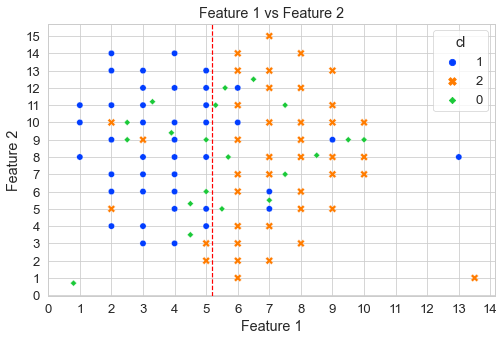

<IPython.core.display.Javascript object>

In [20]:
test_df_temp = test_df.copy()
test_df_temp["cl"] = 0

plt.figure(figsize=(8, 5))

sns.scatterplot(
    x="f1",
    y="f2",
    hue="cl",
    data=pd.concat([train_df, test_df_temp]),
    palette="bright",
    hue_order=[1, 2, 0],
    style="cl",
    markers=["D", "o", "X"],
    size="cl",
    sizes=(20, 60),
)
plt.title("Feature 1 vs Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xticks(ticks=range(0, 15, 1))
plt.yticks(ticks=range(0, 16, 1))
plt.axvline(5.2, linestyle="--", color="r")

plt.savefig("./Output/train-n-test-data-points.png")
plt.show()

1. Every green point on **left side** of the red line belongs to class **`1` - Blue**.
2. Every green point (except `(5.7, 8)`) on **right side** of the red line belongs to class **`2` - Orange**.
3. Green data-point **`(5.7, 8)`** on right of the red line belongs to class **`1` - Blue**.

### Training model with default `K` value `5`

In [21]:
ENABLE_LOG = False
table = PrettyTable(["Data-Point", "Actual Class", "Predicted Class", "Failed"])

try:
    acc = 0
    for index, row in test_df.iterrows():
        x_q = list(row[:2])  # Query point
        acl = int(row[-1])  # Actual class label

        # STEP 1: Get K-nearest neighbors.
        knn = get_k_nearest_points(S, x_q)

        # STEP 2: Get class with majority vote.
        pcl, count = majority_vote(knn)  # Predicted class label and its votes

        # STEP 3: Calculate accuracy.
        sym = "X"
        if acl == pcl:
            acc += 1
            sym = ""

        table.add_row([x_q, acl, pcl, sym])

    print("Testing model using `test` dataset:")
    print(table)

except ValueError as ve:
    print("Error:", ve)

Testing model using `test` dataset:
+-------------+--------------+-----------------+--------+
|  Data-Point | Actual Class | Predicted Class | Failed |
+-------------+--------------+-----------------+--------+
|  [5.0, 6.0] |      1       |        1        |        |
|  [4.5, 5.3] |      1       |        1        |        |
|  [5.0, 9.0] |      1       |        1        |        |
| [3.3, 11.2] |      1       |        1        |        |
|  [2.5, 9.0] |      1       |        1        |        |
| [2.5, 10.0] |      1       |        1        |        |
|  [5.7, 8.0] |      1       |        2        |   X    |
|  [4.5, 3.5] |      1       |        1        |        |
|  [3.9, 9.4] |      1       |        1        |        |
|  [0.8, 0.7] |      1       |        1        |        |
| [7.5, 11.0] |      2       |        2        |        |
| [10.0, 9.0] |      2       |        2        |        |
|  [9.5, 9.0] |      2       |        2        |        |
|  [8.5, 8.1] |      2       |      

<IPython.core.display.Javascript object>

All Failures are near the border where data-points from both the classes meet.

### Accuracy for default `K` value `5`

Calculate accuracy of KNN algorithm for given `test` dataset when `K` value is `5`.

In [22]:
print("Accuracy of model on test dataset.")
print("Total number of correct predictions:", acc)
print(f"Accuracy: {round(acc / len(test_df) * 100, 1)}%")

Accuracy of model on test dataset.
Total number of correct predictions: 16
Accuracy: 80.0%


<IPython.core.display.Javascript object>

<font color="red">
This approach for calculating accuracy of the model <b>is wrong</b> because the trained model is <b>not generalized</b>.
</font>

# [3] How to pick right hyper parameter `K`?

Find training error for various `K` values raging between `1` and `50` (size of train dataset).

In [23]:
def fit(S, T, K=5):
    try:
        pcl_count = 0  # Correctly predicted class count.
        for dp in T:
            x_q = dp[0]  # Query point
            acl = dp[1]  # Actual class label

            # STEP 1: Get K-nearest neighbors.
            knn = get_k_nearest_points(S, x_q, K)

            # STEP 2: Get class with majority vote.
            pcl, count = majority_vote(knn)  # Predicted class label and its votes

            # STEP 3: Compare prediction with actual class-label.
            if acl == pcl:
                # Predicted class-label is same as actual class-label.
                pcl_count += 1

        return round(1 - pcl_count / len(T), 4)  # Training error

    except ValueError as ve:
        print("Error:", ve)

<IPython.core.display.Javascript object>

In [24]:
ENABLE_LOG = False

# Prepare training data.
S = [([row[0], row[1]], row[2]) for _, row in train_df.iterrows()]

train_errors = []
for k in range(1, len(S) + 1):
    trn_err = fit(S, S, k)
    train_errors.append(trn_err)

<IPython.core.display.Javascript object>

Plot training-error vs `K` graph, to get `K` value with lowest error.

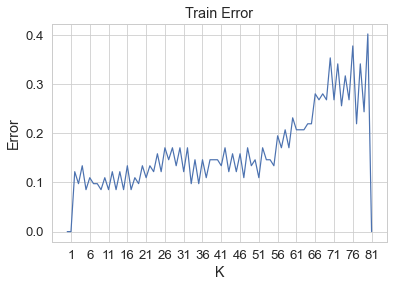

<IPython.core.display.Javascript object>

In [25]:
sns.lineplot(data=train_errors)
plt.title("Train Error")
plt.xlabel("K")
plt.ylabel("Error")
plt.xticks(ticks=range(1, 85, 5))

plt.show()

Train error increases as `K` increases.

# [4] K-Fold Cross Validation

In [26]:
ENABLE_LOG = False
S = np.array([([row[0], row[1]], row[2]) for _, row in train_df.iterrows()], dtype=object)
k_fold = 9

# Split train dataset into k-folds.
splits = np.array_split(S, k_fold)
splits = np.array(splits, dtype=object)  # Typecast to NumPy array

avg_errs = []
for k in range(1, len(S) + 1):
    cval_errs = []
    for index, split in enumerate(splits):
        cross_v = split
        split_c = np.delete(splits, index, axis=0)
        train = np.concatenate(split_c, axis=0, dtype=object)

        cval_err = fit(train, cross_v, k)  # Accuracy percentage
        cval_errs.append(cval_err)
    avg_errs.append(np.mean(cval_errs))

<IPython.core.display.Javascript object>

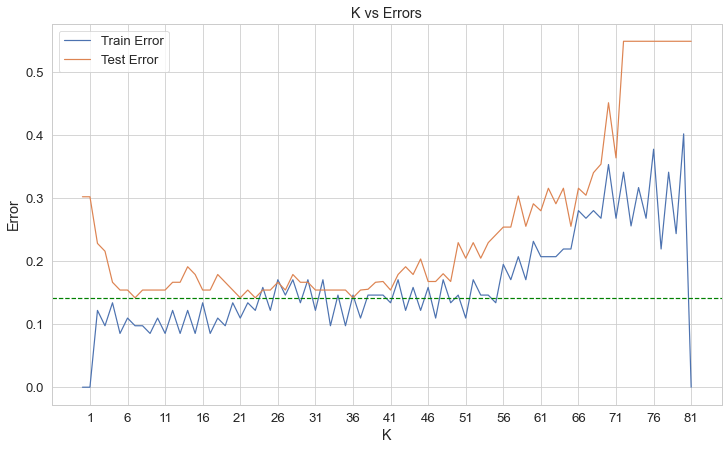

<IPython.core.display.Javascript object>

In [27]:
plt.figure(figsize=(12, 7))

sns.lineplot(data=train_errors, label="Train Error")
sns.lineplot(data=avg_errs, label="Test Error")
plt.title("K vs Errors")
plt.xlabel("K")
plt.ylabel("Error")
plt.xticks(ticks=range(1, 85, 5))
plt.axhline(min(avg_errs), linestyle="--", color="g")
plt.legend()

plt.show()

# [5] Overfitting and Underfitting

Graphical representation of **Overfitting** and **Underfitting**.

# [6] Final Implementation

Final implementation of KNN algorithm by combining all the above steps in single closure.

In [28]:
def KNN(data_pnts):
    """
    Function to prepare training and testing data before applying KNN algorithm.
    """

    # Default values
    dflt_k = 5
    dflt_algo_typ = 1

    # Prepare training data.
    # data_pnts = data_pnts

    def get_k_nearest_points(data_pnts, query_pnt, K=dflt_k, algo_type=dflt_algo_typ):
        """
        Function to return `K` nearest data-points to query-point `query_pnt`.
        """
        if algo_type == 1:
            log("Computing Euclidean Distance.")
            algo = euclidean_distance
        elif algo_type == 2:
            log("Computing Manhattan Distance.")
            algo = manhattan_distance
        elif algo_type == 3:
            log("Computing Minkowski Distance.")
            algo = minkowski_distance
        elif algo_type == 4:
            log("Computing Cosine Distance.")
            algo = cosine_distance
        else:
            raise ValueError(f"Invalid `algo_type` {algo_type}. Value should be in {1, 2, 3, 4}.")

        distances = []
        for data_pnt in data_pnts:
            distances.append(
                {
                    "data-point": data_pnt[0],
                    "label": data_pnt[1],
                    "distance": round(algo(data_pnt[0], query_pnt), 6),
                }
            )

        log(f"Returning {K} nearest neighbors.")
        return sorted(distances, key=lambda x: x["distance"])[:K]

    def majority_vote(knn):
        if is_empty(knn):
            raise ValueError("Class list is empty.")

        # Get class-labels of all data-points and take majority vote/count.
        cl_count = groupby_count(knn, lambda n: n.get("label", None))
        log("Class count:", cl_count)

        # Sort class-labels by count.
        cl_sorted = sorted(cl_count.items(), key=lambda x: x[1], reverse=True)
        log("Class sorted:", cl_sorted)

        # Return class-label with highest count as `y_q`.
        return cl_sorted[0]

    def fit(query_pnt, K=dflt_k, algo_type=dflt_algo_typ):
        """
        Function to apply KNN algorithm on query point `query_pnt` for given `K` value.
        """
        try:
            # STEP 1: Get K-nearest neighbors.
            knn = get_k_nearest_points(data_pnts, query_pnt, K, algo_type)

            # STEP 2: Get class with majority votes.
            return majority_vote(knn)  # Predicted class label and its votes

        except ValueError as err:
            print("Error:", err)

    return fit

<IPython.core.display.Javascript object>

#### Usage example:

In [29]:
def fit(S, T, K=5):
    try:
        pcl_count = 0  # Correctly predicted class count.
        for dp in T:
            x_q = dp[0]  # Query point
            acl = dp[1]  # Actual class label

            # STEP 1: Get K-nearest neighbors.
            knn = get_k_nearest_points(S, x_q, K)

            # STEP 2: Get class with majority vote.
            pcl, count = majority_vote(knn)  # Predicted class label and its votes

            # STEP 3: Calculate accuracy.
            if acl == pcl:
                # Predicted class-label is same as actual class-label.
                pcl_count += 1

        return round(pcl_count / len(T) * 100, 0)  # Accuracy percentage

    except ValueError as ve:
        print("Error:", ve)

<IPython.core.display.Javascript object>

In [30]:
ENABLE_LOG = True

S = [([row[0], row[1]], row[2]) for _, row in train_df.iterrows()]

fit = KNN(S)
pcl, vote = fit((10, 9), 3)

print("Predicted class label:", pcl, "Count:", vote)

Computing Euclidean Distance.
Returning 3 nearest neighbors.
Class count: {2.0: 2, 1.0: 1}
Class sorted: [(2.0, 2), (1.0, 1)]
Predicted class label: 2.0 Count: 2


<IPython.core.display.Javascript object>